In [1]:
import numpy as np 
import pandas as pd 
import cv2
import matplotlib.pyplot as plt
import glob
from skimage.feature import hog
from skimage.transform import resize
from skimage import feature

In [97]:
df_labels = pd.read_csv('dataset/GroundTruth.csv')
df_labels['image'] = 'images/'+ df_labels['image'] +'.jpg'

labels=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
label_list=[]
for i in range (len(df_labels)):
    row= list(df_labels.iloc[i])
    del row[0]
    index=np.argmax(row)
    label=labels[index]
    label_list.append(label)
df_labels['label']= label_list
df_labels=df_labels.drop(labels, axis=1)
#df_labels['label'].value_counts()

In [3]:
df_labels_filtered = pd.DataFrame()
for label in labels:
    df_temp = df_labels[df_labels['label']==label].iloc[:100]
    df_labels_filtered = df_labels_filtered.append(df_temp)
df_labels_filtered['label'].value_counts()

MEL      100
NV       100
BCC      100
AKIEC    100
BKL      100
DF       100
VASC     100
Name: label, dtype: int64

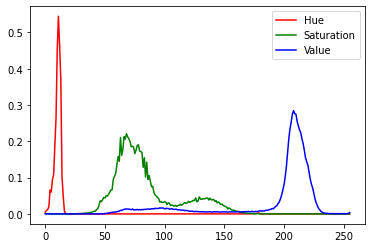

In [5]:
path="dataset/images/ISIC_0024319.jpg"
img = cv2.imread(path)
img2 = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
h, s, v = img2[:,:,0], img2[:,:,1], img2[:,:,2]
hist_h = cv2.calcHist([h],[0],None,[256],[0,256])
hist_h = cv2.normalize(hist_h, hist_h)
hist_s = cv2.calcHist([s],[0],None,[256],[0,256])
hist_s = cv2.normalize(hist_s, hist_s)
hist_v = cv2.calcHist([v],[0],None,[256],[0,256])
hist_v = cv2.normalize(hist_v, hist_v)
plt.plot(hist_h, color='r', label="Hue")
plt.plot(hist_s, color='g', label="Saturation")
plt.plot(hist_v, color='b', label="Value")
plt.legend()
plt.show()

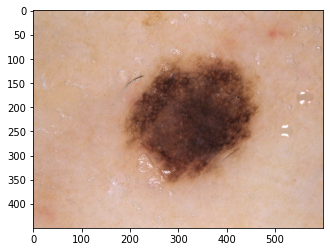

In [6]:
RGB_im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_im)

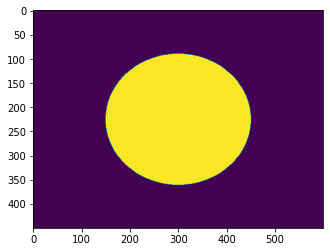

In [7]:
(h, w) = img.shape[:2]
(cX, cY) = (int(w * 0.5), int(h * 0.5))
(axesX, axesY) = (int(w * 0.5) // 2, int(h * 0.6) // 2)
mask = np.zeros(img.shape[:2], dtype = "uint8")
cv2.ellipse(mask, (cX, cY), (axesX, axesY), 0, 0, 360, 255, -1)
plt.imshow(mask)

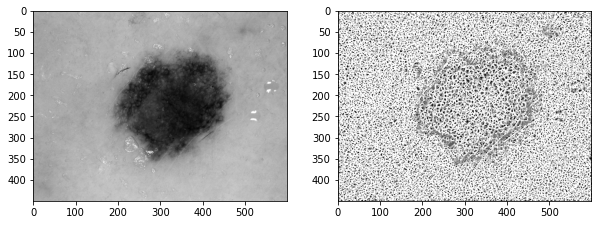

In [8]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
lbp = feature.local_binary_pattern(gray, 126, 3, method="uniform")
fig, axs = plt.subplots(1,2, figsize=(10,10))
axs[0].imshow(gray, cmap='gray')
axs[1].imshow(lbp, cmap='gray')

In [9]:
def HSVdescribe(image, bins=[8,12,8]):
    # Create center mask
    (h, w) = image.shape[:2]
    (cX, cY) = (int(w * 0.5), int(h * 0.5))
    (axesX, axesY) = (int(w * 0.5) // 2, int(h * 0.6) // 2)
    mask = np.zeros(image.shape[:2], dtype = "uint8")
    cv2.ellipse(mask, (cX, cY), (axesX, axesY), 0, 0, 360, 255, -1)
    
    # Get 3D HSV color histogram
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([image], [0, 1, 2], mask, bins, [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist,hist).flatten()
    return hist

In [10]:
def LBPdescribe(image, numPoints=126, radius=3, eps=1e-7):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = feature.local_binary_pattern(gray, numPoints, radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, numPoints + 3), range=(0, numPoints + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + eps)
    return hist

In [11]:
def comb_describe(image):
    fd_lbp = np.array(LBPdescribe(image))
    fd_hsv = np.array(HSVdescribe(image))
    feat = np.hstack([fd_lbp, fd_hsv])
    return feat

In [13]:
def euclidean_distance(x, y):
    dist = np.linalg.norm(x - y)
    return dist

In [14]:
def chi2_distance(x, y, eps = 1e-10):
    dist = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps) for (a, b) in zip(x, y)])
    return dist

In [13]:
# n_features = comb_describe(img).shape[0]

# features_names = ['feature_' + str(i) for i in range(n_features)]
# df_features = pd.DataFrame(columns=features_names)

# img_list = glob.glob('dataset/images/' + "/*.jpg")
# img_list = [img for img in img_list if img[-16:] in df_labels_filtered['image'].tolist()] 

# for img_path in sorted(img_list):
#     idx = img_path[img_path.rfind("/") + 1:] #Pick de name of the image as index "*.jpg"
#     image = cv2.imread(img_path)
#     features = comb_describe(image)
#     df_features.loc[idx,:] = features # Add the features to the dataframe

In [15]:
df_features = pd.read_csv('features.csv')
df_features = df_features.drop(['Unnamed: 0', 'Unnamed: 0.1','Unnamed: 0.1.1', 'Unnamed: 0.1.1.1'], axis=1)

In [17]:
df_features = df_features.set_index('Unnamed: 0.1.1.1.1')
df_features

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_886,feature_887,feature_888,feature_889,feature_890,feature_891,feature_892,feature_893,feature_894,feature_895
Unnamed: 0.1.1.1.1,,,,,,,,,,,,,,,,,,,,,
images/ISIC_0024306.jpg,0.047344,0.007422,0.002393,0.002822,0.003737,0.003822,0.003356,0.004067,0.004363,0.004341,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
images/ISIC_0024307.jpg,0.050378,0.007059,0.002444,0.003230,0.003833,0.004181,0.003822,0.004137,0.004711,0.004507,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
images/ISIC_0024308.jpg,0.057759,0.006689,0.002685,0.003470,0.003756,0.004307,0.003874,0.004400,0.004593,0.004744,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
images/ISIC_0024309.jpg,0.048078,0.007452,0.002256,0.002781,0.003367,0.003841,0.003219,0.004019,0.004215,0.004348,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
images/ISIC_0024310.jpg,0.044981,0.003759,0.002319,0.002941,0.003070,0.003500,0.003367,0.003670,0.003926,0.003781,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
images/ISIC_0032468.jpg,0.052330,0.006233,0.002296,0.002926,0.003193,0.004141,0.003744,0.004715,0.004652,0.005041,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
images/ISIC_0032613.jpg,0.045344,0.004130,0.002167,0.002504,0.002767,0.003133,0.003030,0.003581,0.004081,0.004048,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
images/ISIC_0032642.jpg,0.032915,0.004415,0.001330,0.001622,0.001804,0.002578,0.002211,0.002904,0.003107,0.003267,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
df_features.to_csv('features.csv')

In [139]:
def set_query(img_path):
    query_path = 'dataset/images/'+ img_path
    query_image = cv2.imread(query_path)
    RGB_im = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
    label = df_labels[df_labels['image'] == ('images/' + img_path)]['label'].iloc[0]
    plt.imshow(RGB_im)
    plt.title('Query' + ' (' + label + ')')

    query_features = comb_describe(query_image)
    query_features = np.array(query_features)
    
    return query_features

In [143]:
def print_results(top_keys, top_dist):
    fig, axes = plt.subplots(1,5, figsize=(16, 4), sharey=True, sharex=True)
    fig.suptitle('Results', fontsize=14)
    results_img = df_features.loc[top_keys].index
    for idx, img_path in enumerate(results_img):
        ax = axes.flat[idx]
        path = 'dataset/' + img_path
        print(img_path)
        print(path)
        label = df_labels[df_labels['image'] == img_path]['label'].iloc[0]
        image = cv2.imread(path)
        RGB_im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(RGB_im)
        ax.set_title(str(round(top_dist[idx], 2)) + ' (' + label + ')')
    
    return None

images/ISIC_0024306.jpg
dataset/images/ISIC_0024306.jpg
images/ISIC_0024307.jpg
dataset/images/ISIC_0024307.jpg
images/ISIC_0024308.jpg
dataset/images/ISIC_0024308.jpg
images/ISIC_0024309.jpg
dataset/images/ISIC_0024309.jpg
images/ISIC_0024310.jpg
dataset/images/ISIC_0024310.jpg


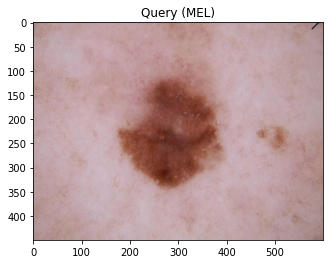

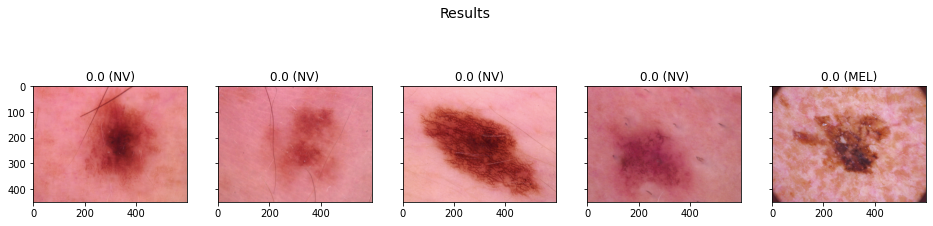

In [144]:
query_features = set_query('ISIC_0031025.jpg')
(top_5_keys, top_5_dist) = search(query_features, distance=chi2_distance)
print_results(top_5_keys, top_5_dist)

images/ISIC_0024306.jpg
dataset/images/ISIC_0024306.jpg
images/ISIC_0024307.jpg
dataset/images/ISIC_0024307.jpg
images/ISIC_0024308.jpg
dataset/images/ISIC_0024308.jpg
images/ISIC_0024309.jpg
dataset/images/ISIC_0024309.jpg
images/ISIC_0024310.jpg
dataset/images/ISIC_0024310.jpg


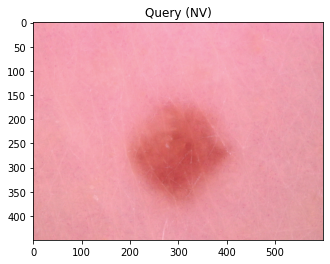

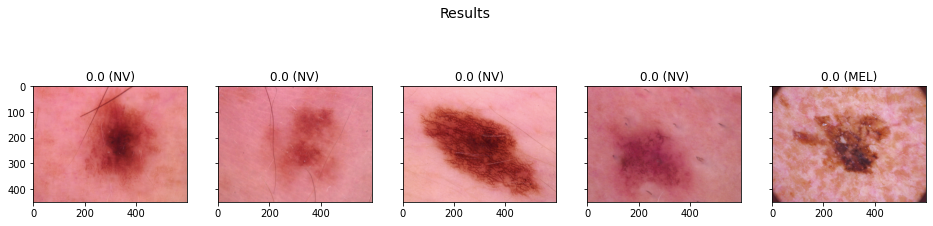

In [148]:
query_features = set_query('ISIC_0024574.jpg')
(top_5_keys, top_5_dist) = search(query_features, distance=euclidean_distance)
print_results(top_5_keys, top_5_dist)

In [56]:
print("\I")

\I
